In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

from utils import display_metrics

In [28]:
df = pd.read_csv('energy_antananarivo_cleaned.csv', index_col='date', parse_dates=True)

In [29]:
# Suppresion de la colonne 'tot_energy'
df = df.drop('tot_nb_dmd', axis=1)
df.reset_index(drop=True)
df

,tot_energy
date,
2000-01-01,0.006076
2000-02-01,0.006279
2000-03-01,0.006266
2000-04-01,0.006196
2000-05-01,0.005935
...,...
2023-08-01,0.022818
2023-09-01,0.022779
2023-10-01,0.022121


In [30]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.sa import ARIMA

# Decompostion saisonnière
decomposition = seasonal_decompose(df.tot_energy, model='additive', period=1)

# Extraction des composantes de la decomposotion
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [31]:
differenced = df.tot_energy.diff().dropna()

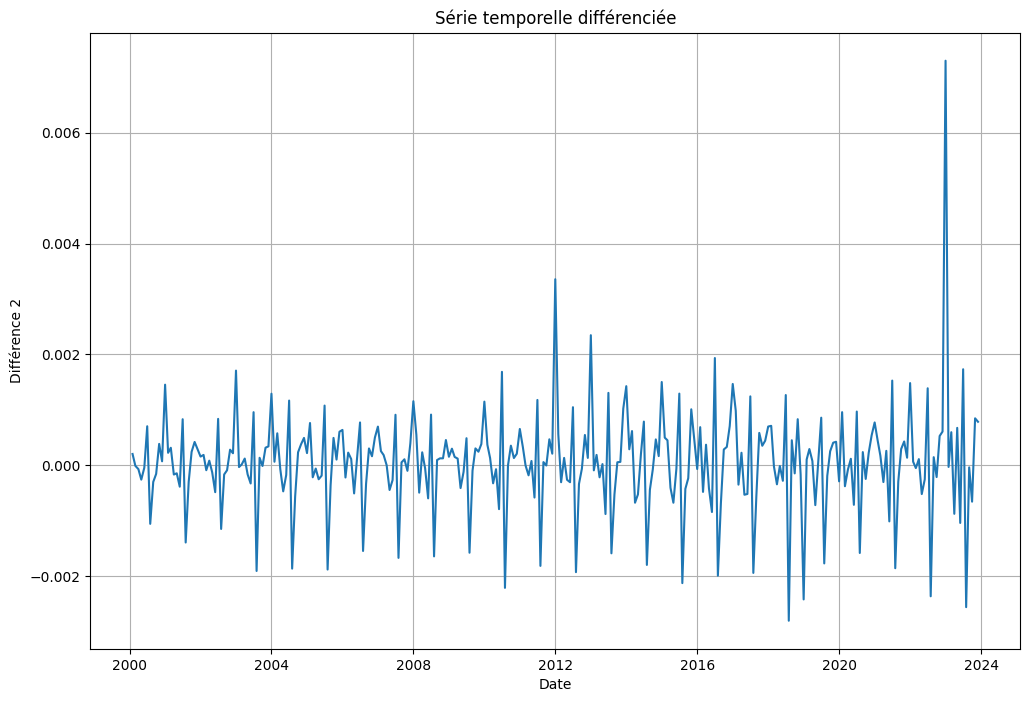

In [32]:
# Afficher la série différenciée
plt.figure(figsize=(12,8))
plt.plot(differenced)
plt.title('Série temporelle différenciée')
plt.xlabel('Date')
plt.ylabel('Différence 2')
plt.grid(True)
plt.show()

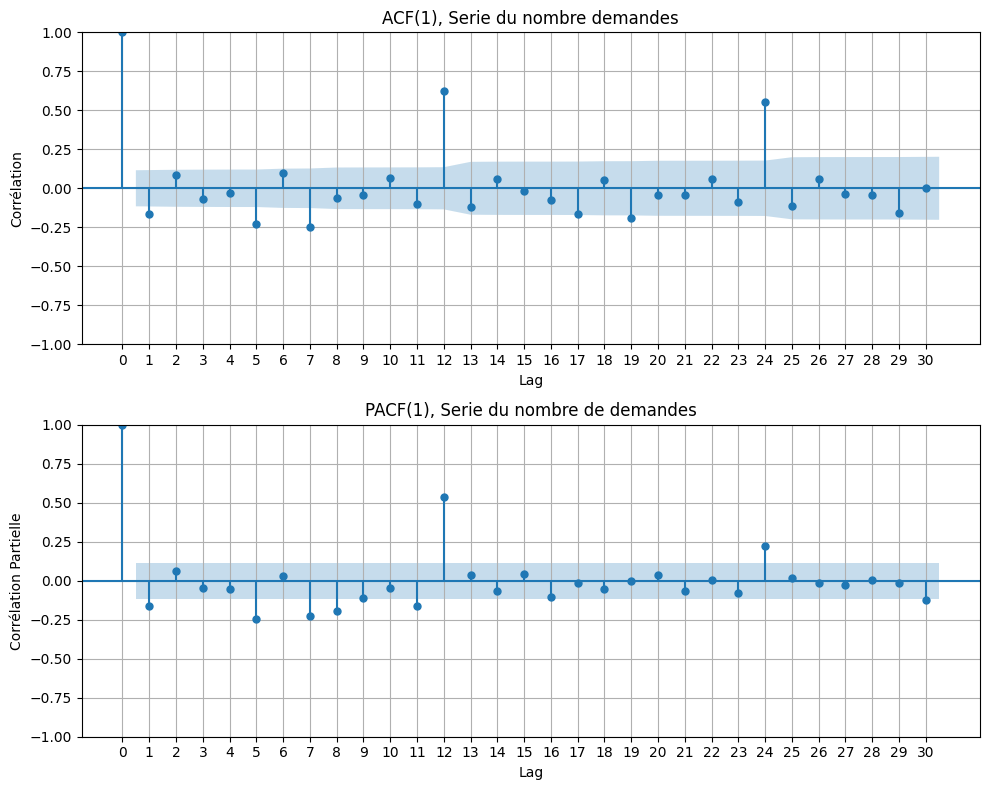

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage de l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF(1), Serie du nombre demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage du PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF(1), Serie du nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement des graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement des subplots
plt.tight_layout()

plt.show()

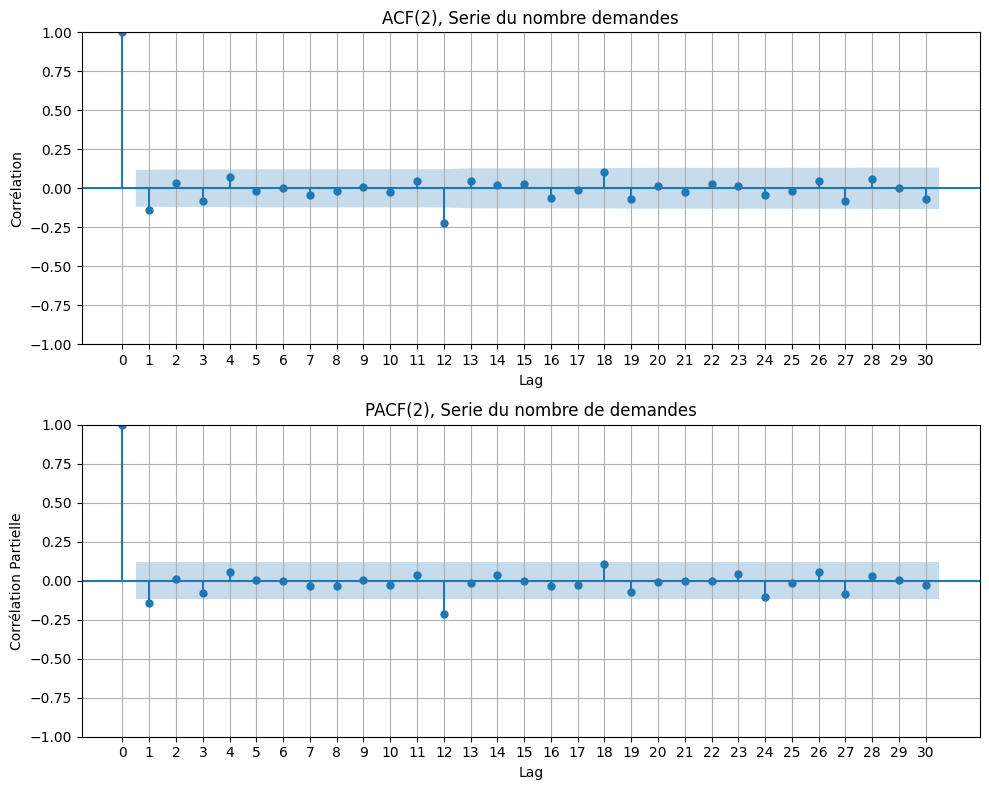

In [34]:
differenced_2 = differenced.diff(12).dropna()

# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage de l'ACF
plot_acf(differenced_2, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF(2), Serie du nombre demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage du PACF
plot_pacf(differenced_2, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF(2), Serie du nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement des graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement des subplots
plt.tight_layout()

plt.show()

In [35]:
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Test de Dickey-Fuller augmenté
result = adfuller(differenced_2)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -6.348263492659514        |
| P-valeur       | 2.6497188706760942e-08    |
| Conclusion     | La série est stationnaire |


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [37]:
# Separer les données en set de train et set de test
# train = df.tot_nb_dmd[:-15]
# test = df.tot_nb_dmd[-15:]
train = differenced_2[:-15]
test = differenced_2[-15:]

model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))

# Ajustement du modèle
model_sarima_fit = model_sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.45628D+00    |proj g|=  5.65570D+02


 This problem is unconstrained.



At iterate    5    f= -5.61665D+00    |proj g|=  1.14157D+00
  ys=-4.640E-09  -gs= 1.521E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     64      1     1     0   1.135D+00  -5.617D+00
  F =  -5.6166548633617523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [38]:
train.shape

(260,)

In [39]:
test.shape

(15,)

<Figure size 1200x800 with 0 Axes>

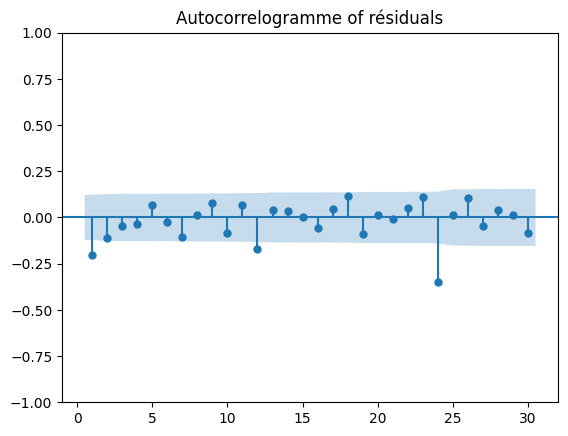

<Figure size 1200x800 with 0 Axes>

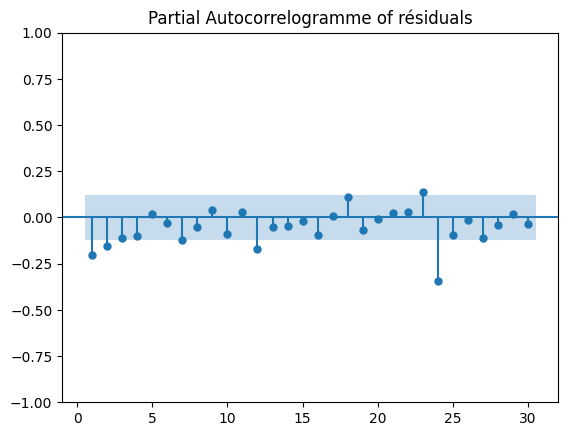

In [40]:
# calculer les résidus
residuals = model_sarima_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(12,8))
plot_acf(residuals, lags=30, zero=False)
plt.title('Autocorrelogramme of résiduals')
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(12,8))
plot_pacf(residuals, lags=30, zero=False)
plt.title('Partial Autocorrelogramme of résiduals')
plt.show()

In [41]:
model_sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         tot_energy   No. Observations:                  260
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1460.330
Date:                            Sun, 24 Mar 2024   AIC                          -2910.661
Time:                                    16:37:35   BIC                          -2893.114
Sample:                                02-01-2001   HQIC                         -2903.596
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1142      0.079     -1.442      0.149      -0.269       0.041
ma.L1         -0.7852      0.058    -13.440      0.000      -0.900      -0.671
ar.S.L12      -0.4443      0.040    -11.094      0.000      -0.523      -0.366
ma.S.L12      -0.6436      0.058    -11.042      0.000      -0.758      -0.529
sigma2      4.072e-07   2.66e-08     15.285      0.000    3.55e-07    4.59e-07
===================================================================================
Ljung-Box (L1) (Q):                   7.61   Jarque-Bera (JB):               223.29
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

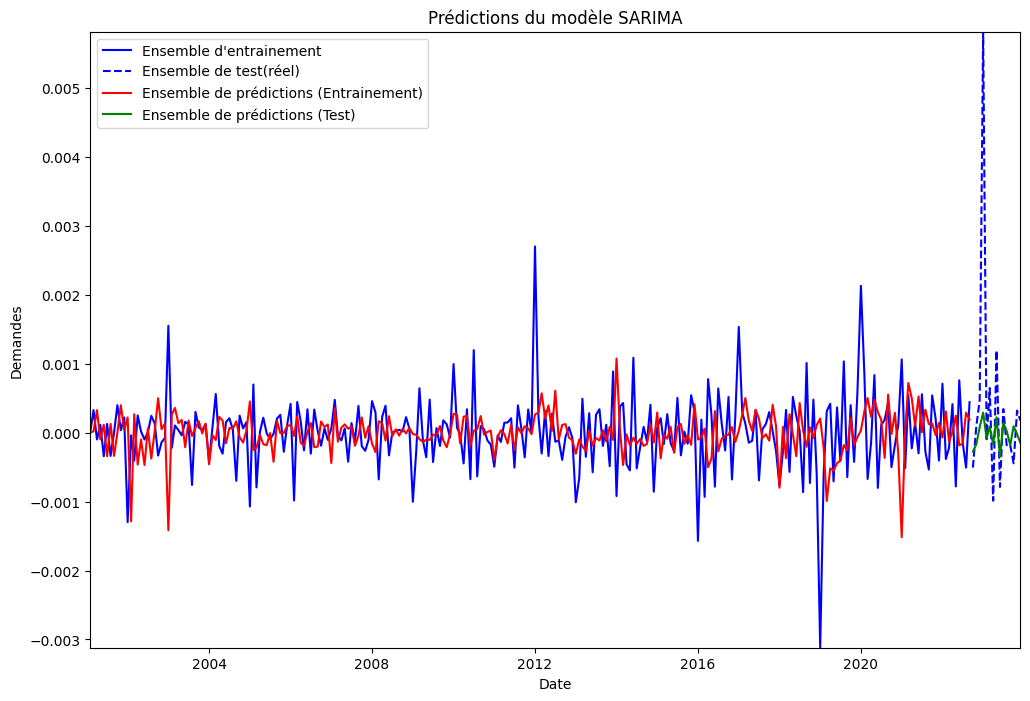

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prédiction sur l'ensemble d'entrainement
train_prediction = model_sarima_fit.predict(start=train.index[0], end=train.index[-1])

# Prédiction sur l'ensemble de test
test_prediction = model_sarima_fit.predict(start=test.index[0], end=test.index[-1])

# Traçage des predictions et les données réels avec les courbes collées.
plt.figure(figsize=(12,8))
plt.plot(train.index, train.values, label='Ensemble d\'entrainement', color='blue')
plt.plot(test.index, test.values, label='Ensemble de test(réel)', linestyle='--', color='blue')
plt.plot(train_prediction.index, train_prediction.values, label='Ensemble de prédictions (Entrainement)', color='red')
plt.plot(test_prediction.index, test_prediction.values, label='Ensemble de prédictions (Test)', color='green')

# Définition des limites des axes x et y pour une continuté visuelle.
plt.xlim(train.index[0], test.index[-1])
plt.ylim(min(train.min(), test.min()), max(train.max(), test.max()))

plt.xlabel('Date')
plt.ylabel('Demandes')
plt.title('Prédictions du modèle SARIMA')
plt.legend()
plt.show()

In [43]:
# Mesures de performances sur l'ensemble de set et de prediction
perf_df = display_metrics(train, train_prediction, test, test_prediction)
perf_df

,Métriques:,Ensemble d'entrainenemt:,Ensemble de test:
0,MAE,4.593193e-04,0.000722
1,MSE,4.303059e-07,0.000002
2,RMSE,6.559770e-04,0.001495
3,R²,-4.581436e-01,0.068905


In [44]:
# Evaluation automatique 
import pmdarima as pm

# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
optimized_model =  pm.auto_arima(train, seasonal=True, m=12)

print(optimized_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  260
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood                1639.227
Date:                                 Sun, 24 Mar 2024   AIC                          -3270.453
Time:                                         16:38:34   BIC                          -3256.211
Sample:                                     02-01-2001   HQIC                         -3264.728
                                          - 09-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2106      0.037     -5.645      0.000      -0.284      -0

In [45]:
test.index[0]

Timestamp('2022-10-01 00:00:00')

In [46]:
# # Ré-entrainement avec les nouveaux paramètres
# final_model_sarima = SARIMAX(train, order=(5,0,0), seasonal_order=(2,0,0,12))

# # Ajustement du modèle
final_model_sarima_fit = optimized_model.fit(train)

# Recup du set d'entrainement
# fitted_train = final_model_sarima.predict_in_sample()

# Prédictions pour les données de test
predictions = optimized_model.predict(n_periods=len(test))
# predictions = optimized_model.predict(y=test, start=test.index[0], end=test.index[-1], dynamic=False)

# Calcul de l'erreur RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

RMSE: 0.0017421349919420593


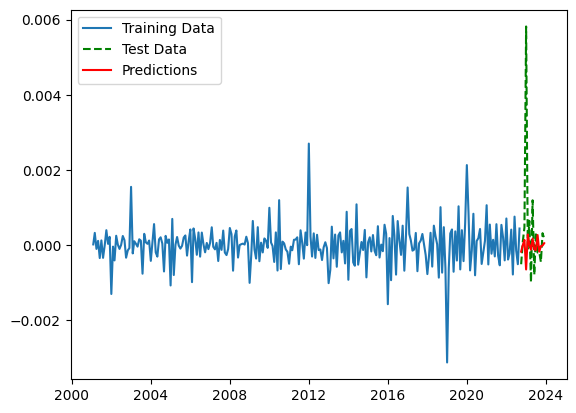

In [47]:
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='green', linestyle='--')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.show()

In [48]:
predictions = model_sarima_fit.predict(start=test.index[0], end=test.index[-1])

# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test, predictions)
test_mse = mean_squared_error(test, predictions)
test_rmse = mean_squared_error(test, predictions, squared=False)
test_r2 = r2_score(test, predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

,Métriques:,Ensemble de test:
0,MAE,0.000722
1,MSE,0.000002
2,RMSE,0.001495
3,R²,0.068905


In [49]:
# Entrainement avec toutes les données
# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
optimized_model =  pm.auto_arima(df, seasonal=True, m=12)

print(optimized_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  288
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                1712.299
Date:                                 Sun, 24 Mar 2024   AIC                          -3412.598
Time:                                         16:40:18   BIC                          -3390.641
Sample:                                     01-01-2000   HQIC                         -3403.798
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1586      0.054     -2.918      0.004      -0.265      -0

In [51]:
model_sarima = SARIMAX(df, order=(1, 1, 0), seasonal_order=(2, 0, [1, 2], 12), enforce_stationarity=False, trend='c', enforce_invertibility=False)
optimized_model = model_sarima.fit()
predictions = optimized_model.forecast(15)
predictions

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.31378D+00    |proj g|=  5.45763D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     19      1     0     0   6.186D+00  -5.427D+00
  F =  -5.4274877452491719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


2024-01-01    0.028759
2024-02-01    0.028830
2024-03-01    0.029253
2024-04-01    0.028695
2024-05-01    0.029082
2024-06-01    0.028284
2024-07-01    0.029829
2024-08-01    0.027580
2024-09-01    0.027564
2024-10-01    0.027159
2024-11-01    0.027869
2024-12-01    0.028530
2025-01-01    0.033157
2025-02-01    0.033252
2025-03-01    0.033633
Freq: MS, Name: predicted_mean, dtype: float64

In [52]:
import pickle
with open('consommation_fit.pkl', 'wb') as pkl_file:
    pickle.dump(optimized_model, pkl_file)

In [54]:
df.tail()

,tot_energy
date,
2023-08-01,0.022818
2023-09-01,0.022779
2023-10-01,0.022121
2023-11-01,0.022967
2023-12-01,0.023751
